In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import tensorflow 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tamil
from tamil.utf8 import get_words
import unicodedata
# Tools for Tamil Text
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from transformers import BertTokenizer, BertModel

In [9]:
images_dir = 'images'
train_dir = 'train'
val_dir = 'dev'
test_dir = 'test'

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('Mal_test_with_labels.csv')

train_text = train_df['transcriptions'].tolist()
train_labels = train_df['labels']
train_image_id = train_df['image_id']

val_text = val_df['transcriptions'].tolist()
val_labels = val_df['labels']
val_image_id = val_df['image_id']

test_text = test_df['transcriptions'].tolist()
test_image_id = test_df['image_id']
test_labels = test_df['labels']

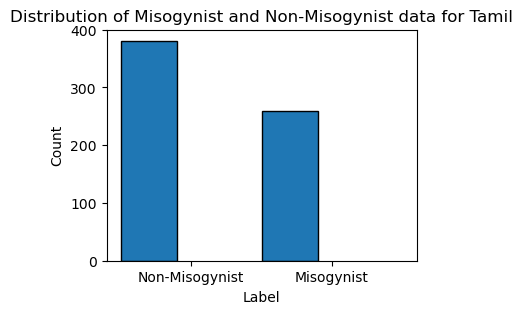

In [10]:
# Plotting the distribution of labels
plt.figure(figsize=(4, 3))
plt.hist(train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', width=0.4)
plt.xticks([0, 1], ['Non-Misogynist', 'Misogynist'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Misogynist and Non-Misogynist data for Tamil')
plt.show()

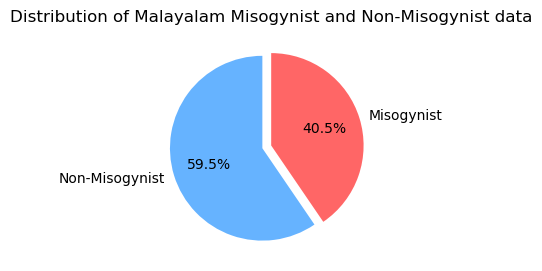

In [11]:
# Count occurrences of each label (0 and 1)
label_counts = train_labels.value_counts()

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=['Non-Misogynist', 'Misogynist'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=90, explode=(0.1, 0)) 

# Adding title
plt.title('Distribution of Malayalam Misogynist and Non-Misogynist data')
plt.show()

In [12]:
len(train_df), len(val_df), len(test_df)

(640, 159, 200)

In [13]:
len(os.listdir(train_dir)), len(os.listdir(val_dir)), len(os.listdir(test_dir))

(639, 160, 200)

In [14]:
# List all files in the images directory
available_images = set(os.listdir(images_dir))
# Function to check if all image IDs are in the directory
def check_image_ids(image_ids, images_dir):
    missing_images = [] 
    for image_id in image_ids:
        image_filename = f"{image_id}.jpg" 
        if image_filename not in available_images:
            missing_images.append(image_filename)
    return missing_images

In [15]:
import shutil
# output_dir = 'images'
# os.makedirs(output_dir, exist_ok=True)
# # Function to copy files from source to destination
# def copy_files(src_dir, dest_dir): 
#     for file_name in os.listdir(src_dir):
#         src_path = os.path.join(src_dir, file_name) 
#         dest_path = os.path.join(dest_dir, file_name)
#         if os.path.isfile(src_path):  # Check if it's a file
#             shutil.copy(src_path, dest_path)

# # Copy files from val_dir and test_dir to output_dir
# copy_files(train_dir, output_dir)
# copy_files(val_dir, output_dir)
# copy_files(test_dir, output_dir)

In [16]:
# Get unique image IDs from the DataFrames
# train_image_ids = train_df['image_id'].unique()
# val_image_ids = val_df['image_id'].unique()
# test_image_ids = test_df['image_id'].unique()

# Check for missing images in each set
missing_train_images = check_image_ids(train_image_id, images_dir)
missing_val_images = check_image_ids(val_image_id, images_dir)
missing_test_images = check_image_ids(test_image_id, images_dir)

In [17]:
len(missing_train_images), len(missing_val_images), len(missing_test_images)

(0, 0, 0)

In [18]:
type(train_text)

list

In [41]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
model = AutoModel.from_pretrained("google/muril-base-cased")
inputs = tokenizer(train_text, padding=True, truncation=True, return_tensors="pt", max_length=30)
val_input = tokenizer(val_text, padding=True, truncation=True, return_tensors="pt", max_length=30)
test_input = tokenizer(test_text, padding=True, truncation=True, return_tensors="pt", max_length=30)


c:\Users\nimmi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [42]:
with torch.no_grad():
    train_features = model(**inputs).pooler_output 
    val_features = model(**val_input).pooler_output 
    test_features = model(**test_input).pooler_output

In [48]:
np.save('train_features.npy', np.array(train_features))
np.save('val_features.npy', np.array(val_features))
np.save('test_features.npy', np.array(test_features))

In [43]:
train_features.shape, val_features.shape, test_features.shape

(torch.Size([640, 768]), torch.Size([159, 768]), torch.Size([200, 768]))

In [19]:
train_features = np.load('train_features.npy')
val_features = np.load('val_features.npy')
test_features = np.load('test_features.npy')

train_image_features = np.load('train_image_features.npy')
val_image_features = np.load('val_image_features.npy')
test_image_features = np.load('test_image_features.npy')

# Convert NumPy arrays to PyTorch tensors
train_image_features = torch.from_numpy(train_image_features)
val_image_features = torch.from_numpy(val_image_features)
test_image_features = torch.from_numpy(test_image_features)

# Convert NumPy arrays to PyTorch tensors
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)
test_features = torch.from_numpy(test_features)

In [45]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from torchvision import transforms
from PIL import Image

# Load Vision Transformer (ViT) feature extractor and model once
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model_vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
model_vit.eval()  # Set model to evaluation mode

# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Function to extract image features
def extract_image_features(image_ids, images_dir):
    image_features = []
    
    for image_id in image_ids:
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
            image = preprocess(image).unsqueeze(0)  # Add batch dimension
            
            # Extract features using ViT
            with torch.no_grad():
                outputs = model_vit(image)
                features = outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()  # Mean pooling
            image_features.append(features)
        except Exception as e:
            print(f"Error loading image {image_id}.jpg: {e}")
            image_features.append(None)
    
    return image_features


c:\Users\nimmi\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# Extract image features for train, validation, and test sets
train_image_features = extract_image_features(train_df['image_id'], images_dir)
val_image_features = extract_image_features(val_df['image_id'], images_dir)
test_image_features = extract_image_features(test_df['image_id'], images_dir)

In [47]:
# Save train, validation, and test image features to NumPy files
np.save('train_image_features.npy', np.array(train_image_features))
np.save('val_image_features.npy', np.array(val_image_features))
np.save('test_image_features.npy', np.array(test_image_features))

# Load the saved image features from NumPy files
# train_image_features = np.load('train_image_features.npy')
# val_image_features = np.load('val_image_features.npy')
# test_image_features = np.load('test_image_features.npy')


In [20]:
len(train_image_features)

640

In [21]:
train_image_features[0].shape, val_image_features[0].shape, test_image_features[0].shape

(torch.Size([768]), torch.Size([768]), torch.Size([768]))

In [52]:
import torch
train_image_features = torch.tensor(train_image_features)
val_image_features = torch.tensor(val_image_features)
test_image_features = torch.tensor(test_image_features)


C:\Users\nimmi\AppData\Local\Temp\ipykernel_23776\1804426924.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  train_image_features = torch.tensor(train_image_features)


In [23]:
train_image_features.shape, train_features.shape

(torch.Size([640, 768]), torch.Size([640, 768]))

COMBINE TEXT AND IMAGE FEATURES

In [24]:
# Combine image and text features into a single DataFrame
def combine_features(text_features, image_features):
    combined_features = torch.cat((text_features, image_features), dim=1)
    return combined_features 

In [25]:
# Combine features for train, validation, and test sets
train_combined_features = combine_features(train_features, train_image_features)
val_combined_features = combine_features(val_features, val_image_features)
test_combined_features = combine_features(test_features, test_image_features)

In [26]:
# Print the shape of combined features
print("Train combined features shape:", train_combined_features.shape) 
print("Validation combined features shape:", val_combined_features.shape)
print("Test combined features shape:", test_combined_features.shape)

Train combined features shape: torch.Size([640, 1536])
Validation combined features shape: torch.Size([159, 1536])
Test combined features shape: torch.Size([200, 1536])


In [27]:
import torch
import torch.nn as nn

class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultimodalClassifier, self).__init__()
        
        # Shared subnetwork for both text and image features (since they are combined)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # input_dim = 1536 (text + image features)
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2)
        )
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),  # output_dim = 1 for binary classification
            nn.Sigmoid()  # Sigmoid for binary classification
        )
    
    def forward(self, combined_features):
        # Pass combined features (text + image) through the network
        x = self.fc(combined_features)
        output = self.classifier(x)
        return output


In [28]:
train_labels1 = torch.tensor(train_labels.values).float()
val_labels1 = torch.tensor(val_labels.values).float()
test_labels1 = torch.tensor(test_labels.values).float()

In [30]:
# Training function
def train_epoch(model, train_features, train_labels, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_features)

    # Calculate loss
    loss = criterion(outputs.squeeze(), train_labels)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    predicted_labels = (outputs.squeeze() > 0.5).float()
    accuracy = accuracy_score(train_labels.cpu().numpy(), predicted_labels.cpu().numpy())
    
    return loss.item(), accuracy

# Evaluation function
def evaluate(model, val_features, val_labels, criterion):
    model.eval()
    
    with torch.no_grad():
        outputs = model(val_features)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), val_labels)
        
        # Calculate predicted labels
        predicted_labels = (outputs.squeeze() > 0.5).float()
        
        # Metrics calculation
        accuracy = accuracy_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        precision = precision_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        recall = recall_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        f1 = f1_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        
    return loss.item(), accuracy, precision, recall, f1


In [36]:
# Testing function
def test(model, test_features):
    model.eval()
    
    with torch.no_grad():
        outputs = model(test_features)
        
        # Convert outputs to predicted labels
        predicted_labels = (outputs.squeeze() > 0.5).float()
        
    return predicted_labels

In [127]:
# Example dimensions
input_dim = 1536  # Combined text and image features (768 + 768)
hidden_dim = 256  # Hidden dimension size 
output_dim = 1    # Binary classification (0 or 1)

# Initialize model
model = MultimodalClassifier(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=.00004) 

                precision    recall  f1-score   support

Non-Misogynist       0.89      0.89      0.89       122
    Misogynist       0.82      0.83      0.83        78

      accuracy                           0.86       200
     macro avg       0.86      0.86      0.86       200
  weighted avg       0.87      0.86      0.87       200



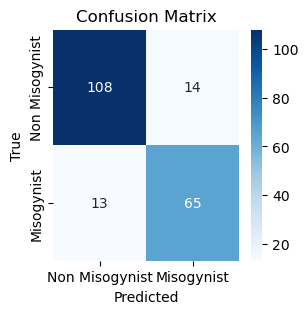

In [116]:
num_epochs = 320
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_combined_features, train_labels1, optimizer, criterion)
from sklearn.metrics import classification_report
test_predictions = test(model, test_combined_features)
report = classification_report(test_labels, test_predictions, target_names=['Non-Misogynist', 'Misogynist'])
print(report)
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

SVM Accuracy: 0.855
                precision    recall  f1-score   support

Non-Misogynist       0.88      0.89      0.88       122
    Misogynist       0.82      0.81      0.81        78

      accuracy                           0.85       200
     macro avg       0.85      0.85      0.85       200
  weighted avg       0.85      0.85      0.85       200



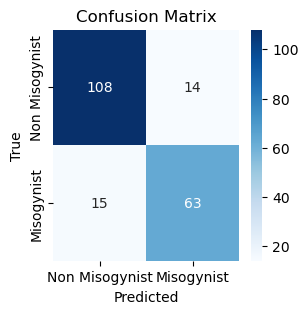

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# test_labels = test_labels['labels']

# Scale features (important for KNN, SVM)
scaler = StandardScaler()
train_combined_features1 = scaler.fit_transform(train_combined_features)
test_combined_features1 = scaler.transform(test_combined_features)

# SVM
svm_model = SVC(kernel='rbf', C= 3, gamma= 'auto')
svm_model.fit(train_combined_features1, train_labels)
y_test_svm = svm_model.predict(test_combined_features1)
print("SVM Accuracy:", accuracy_score(test_labels, y_test_svm))
report = classification_report(test_labels, y_test_svm, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

cm = confusion_matrix(test_labels, y_test_svm)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

Random Forest Accuracy: 0.855
                precision    recall  f1-score   support

Non-Misogynist       0.85      0.93      0.89       122
    Misogynist       0.87      0.74      0.80        78

      accuracy                           0.85       200
     macro avg       0.86      0.83      0.84       200
  weighted avg       0.86      0.85      0.85       200



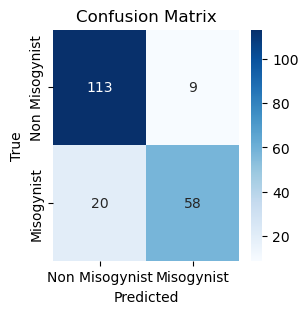

In [100]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf_model = RandomForestClassifier(n_estimators= 250, random_state=100, min_samples_split = 5, min_samples_leaf = 1, criterion = 'gini', max_features = 'sqrt')
rf_model.fit(train_combined_features, train_labels)
y_pred_rf = rf_model.predict(test_combined_features)
print("Random Forest Accuracy:", accuracy_score(test_labels, y_pred_rf))  
report = classification_report(test_labels, y_pred_rf, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

cm = confusion_matrix(test_labels, y_pred_rf)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

                precision    recall  f1-score   support

Non-Misogynist       0.81      1.00      0.89       122
    Misogynist       1.00      0.63      0.77        78

      accuracy                           0.85       200
     macro avg       0.90      0.81      0.83       200
  weighted avg       0.88      0.85      0.85       200



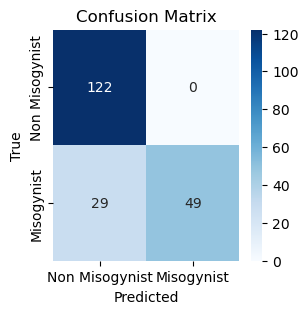

In [94]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=64, weights = 'uniform', algorithm = 'kd_tree', metric='minkowski')
knn_model.fit(train_combined_features, train_labels)
y_pred_knn = knn_model.predict(test_combined_features)
report = classification_report(test_labels, y_pred_knn, target_names=['Non-Misogynist', 'Misogynist'])
print(report) 

cm = confusion_matrix(test_labels, y_pred_knn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

                precision    recall  f1-score   support

Non-Misogynist       0.87      0.82      0.84       122
    Misogynist       0.74      0.81      0.77        78

      accuracy                           0.81       200
     macro avg       0.81      0.81      0.81       200
  weighted avg       0.82      0.81      0.82       200



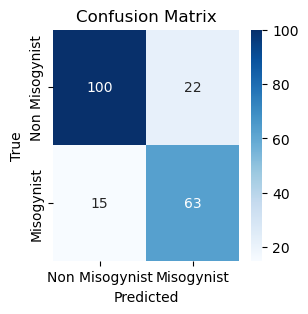

In [45]:
# Naive Bayes (not ideal for embeddings)
nb_model = GaussianNB()
nb_model.fit(train_combined_features, train_labels)
y_pred_nb = nb_model.predict(test_combined_features)
report = classification_report(test_labels, y_pred_nb, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

cm = confusion_matrix(test_labels, y_pred_nb)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [46]:
train_combined_features1 = train_combined_features.reshape(train_combined_features.shape[0], 1, train_combined_features.shape[1])
val_combined_features1 = val_combined_features.reshape(val_combined_features.shape[0], 1, val_combined_features.shape[1])
test_combined_features1 = test_combined_features.reshape(test_combined_features.shape[0], 1, test_combined_features.shape[1])

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Assuming combined_embeddings is your input data, and labels are the targets
# combined_embeddings.shape -> (num_samples, time_steps, feature_dim)
# labels.shape -> (num_samples,)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(train_combined_features1.shape[1], train_combined_features1.shape[2])),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(32, activation='tanh'),  #tanh
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])


# Compile the Model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(train_combined_features1, train_labels, epochs=15, batch_size=64, validation_data=(val_combined_features1, val_labels))

Epoch 1/15


c:\Users\nimmi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.6695 - loss: 0.6336 - val_accuracy: 0.8491 - val_loss: 0.4276
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8443 - loss: 0.3990 - val_accuracy: 0.8491 - val_loss: 0.4147
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8871 - loss: 0.3036 - val_accuracy: 0.8428 - val_loss: 0.4211
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9134 - loss: 0.2360 - val_accuracy: 0.8050 - val_loss: 0.4561
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9240 - loss: 0.1997 - val_accuracy: 0.8050 - val_loss: 0.5237
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9559 - loss: 0.1433 - val_accuracy: 0.8491 - val_loss: 0.4843
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9290 - loss: 0.1551 - val_accuracy: 0.8491 - val_loss: 0.5203
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9612 - loss: 0.1059 - val_accuracy: 0.8491 - val_loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       122
           1       0.84      0.85      0.84        78

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.88      0.88      0.88       200



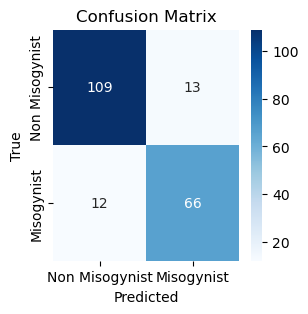

In [60]:
from sklearn.metrics import classification_report

# Predict and round off probabilities for binary classification 
y_pred_rnn = model.predict(test_combined_features1) 
y_pred_rnn = (y_pred_rnn > .5).astype(int)  

# Calculate and print metrics 
print(classification_report(test_labels, y_pred_rnn))

cm = confusion_matrix(test_labels, y_pred_rnn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [78]:
from tensorflow.keras.layers import GRU, Dense, Dropout

# Define the GRU model
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(train_combined_features1.shape[1], train_combined_features1.shape[2])),
    Dropout(0.1),
    GRU(64),
    Dropout(0.1),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
# print(model.summary())


c:\Users\nimmi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
# Train the model
history = model.fit(
    train_combined_features1, train_labels,
    validation_data=(val_combined_features1, val_labels),
    batch_size=16, 
    epochs=20,
    verbose=1
)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9948 - loss: 0.0043 - val_accuracy: 0.8113 - val_loss: 1.1892
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9972 - loss: 0.0039 - val_accuracy: 0.8176 - val_loss: 1.1721
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9974 - loss: 0.0023 - val_accuracy: 0.8176 - val_loss: 1.1750
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9997 - loss: 5.8982e-04 - val_accuracy: 0.8176 - val_loss: 1.1795
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9999 - loss: 7.9369e-04 - val_accuracy: 0.8176 - val_loss: 1.1913
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9957 - loss: 0.0056 - val_accuracy: 0.8176 - val_loss: 1.1930
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9991 - loss: 0.0015 - val_accuracy: 0.8176 - val_loss: 1.2027
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9976 - loss: 0.0058 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       122
           1       0.83      0.87      0.85        78

    accuracy                           0.88       200
   macro avg       0.87      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200



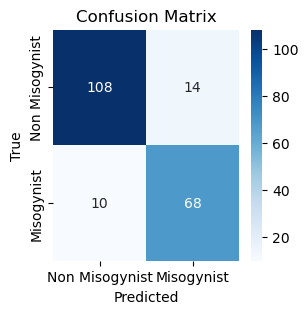

In [62]:
# Evaluate the model on the test set
y_pred = model.predict(test_combined_features1) 
y_pred_binary = (y_pred > 0.5).astype(int) 

# Print classification report  
print(classification_report(test_labels, y_pred_binary))  

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 